In [1]:
import tensorflow as tf

my_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
# Create a and b; they have the same value but are backed by different tensors.
a = tf.Variable(my_tensor, name="Mark")
# A new variable with the same name, but different value
# Note that the scalar add is broadcast
b = tf.Variable(my_tensor + 1, name="Mark")

# These are elementwise-unequal, despite having the same name
print(a == b)


tf.Tensor(
[[False False]
 [False False]], shape=(2, 2), dtype=bool)


In [4]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)
  


In [7]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])
print([dl_dw, dl_db])

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[  5.818829 ,  -3.3420017],
       [ 11.637658 ,  -6.6840034],
       [ 17.456488 , -10.026005 ]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 5.818829 , -3.3420017], dtype=float32)>]


In [9]:
tape.watched_variables()

(<tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
 array([[ 0.5091136, -1.4362627],
        [-1.7762307,  0.556112 ],
        [ 2.954059 , -1.0059876]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>)

In [13]:
x = tf.constant(3.0)
x = tf.Variable(1.0)
with tf.GradientTape() as tape:
  tape.watch(x), tape.watch(y)
  y = x * x
  z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())


2.0


In [14]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])


[  4. 108.]
[2. 6.]


In [15]:
x = tf.constant([1, 3.0])
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])


[  4. 108.]


RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

In [22]:
x = tf.Variable(1.0)
print(x.shape)
x = x + 2

()


In [23]:
x.shape

TensorShape([])

In [25]:
import numpy as np

x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  y = np.mean(x2, axis=0)

  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  tf.convert_to_tensor(y)
  y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))


None


In [26]:
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))


None


In [27]:
# 实际的线
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

# 随机向量x
x = tf.random.normal(shape=[NUM_EXAMPLES])

# 生成噪声
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# 计算y
y = x * TRUE_W + TRUE_B + noise


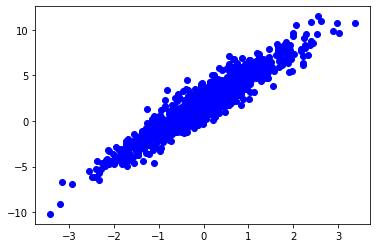

In [28]:
# 绘制所有的数据
import matplotlib.pyplot as plt

plt.scatter(x, y, c="b")
plt.show()


In [29]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # 初始化权重值为`5.0`，偏差值为`0.0`
    # 实际项目中，应该随机初始化
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b


model = MyModel()

# 列出变量tf.modules的内置变量聚合
print("Variables:", model.variables)

# 验证模型是否有效
assert model(3.0).numpy() == 15.0


Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


In [30]:
# 计算整个批次的单个损失值
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))


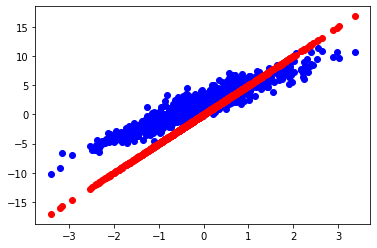

Current loss: 9.145840


In [31]:
plt.scatter(x, y, c="b")
plt.scatter(x, model(x), c="r")
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())


In [ ]:
# 给定一个可调用的模型，输入，输出和学习率...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # 可训练变量由GradientTape自动跟踪
    current_loss = loss(y, model(x))

  # 使用GradientTape计算相对于W和b的梯度
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # 减去由学习率缩放的梯度
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)